# Implement VGG-Net

In [127]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import numpy as np

CONV_KERNEL_SIZE = 3 # constant for convolutional kernels 
POOL_KERNEL_SIZE = 2 # constant for pooling kernels 

class VGG16(nn.Module):
    
    def __init__(self, in_channels: int = 3, num_classes: int = 1000, cifar: bool = False):
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.cifar = cifar
        super(VGG16, self).__init__()
        
        # divide the convolutional feature extraction part of the net
        # from the final fully-connected classification part
        self.conv_features = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, CONV_KERNEL_SIZE), # 224
            nn.ReLU(),
            nn.Conv2d(64, 64, CONV_KERNEL_SIZE),     
            nn.ReLU(),
            nn.MaxPool2d(POOL_KERNEL_SIZE),
            
            nn.Conv2d(64, 128, CONV_KERNEL_SIZE),
            nn.ReLU(),
            nn.Conv2d(128, 128, CONV_KERNEL_SIZE), 
            nn.ReLU(),
            nn.MaxPool2d(POOL_KERNEL_SIZE),
            
            nn.Conv2d(128, 256, CONV_KERNEL_SIZE), 
            nn.ReLU(),
            nn.Conv2d(256, 256, CONV_KERNEL_SIZE), 
            nn.ReLU(),
            nn.Conv2d(256, 256, 1), 
            nn.ReLU(),
            nn.MaxPool2d(POOL_KERNEL_SIZE),
            
            nn.Conv2d(256, 512, CONV_KERNEL_SIZE), 
            nn.ReLU(),
            nn.Conv2d(512, 512, CONV_KERNEL_SIZE),
            nn.ReLU(),
            nn.Conv2d(512, 512, 1),
            nn.ReLU(),
            nn.MaxPool2d(POOL_KERNEL_SIZE),
            
            nn.Conv2d(512, 512, CONV_KERNEL_SIZE), 
            nn.ReLU(),
            nn.Conv2d(512, 512, CONV_KERNEL_SIZE),
            nn.ReLU(),
            nn.Conv2d(512, 512, 1),
            nn.ReLU(),
            nn.MaxPool2d(POOL_KERNEL_SIZE,2),
        ) if not self.cifar else nn.Sequential(
            nn.Conv2d(self.in_channels, 64, CONV_KERNEL_SIZE), # 224
            nn.ReLU(),
            nn.Conv2d(64, 64, CONV_KERNEL_SIZE),     
            nn.ReLU(),
            nn.MaxPool2d(POOL_KERNEL_SIZE),
            
            nn.Conv2d(64, 128, CONV_KERNEL_SIZE),
            nn.ReLU(),
            nn.Conv2d(128, 128, CONV_KERNEL_SIZE), 
            nn.ReLU(),
            nn.MaxPool2d(POOL_KERNEL_SIZE),
            
            nn.Conv2d(128, 256, CONV_KERNEL_SIZE), 
            nn.ReLU(),
            nn.MaxPool2d(POOL_KERNEL_SIZE,2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7,7)) if not cifar else nn.AdaptiveAvgPool2d((5,5))

        # 3 fully connected layers

        self.fc1 = nn.Linear(5*5*256, 64) if self.cifar else nn.Linear(7*7*512, 4096)
        self.fc2 = nn.Linear(64,64) if self.cifar else nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(64,self.num_classes) if self.cifar else nn.Linear(4096, self.num_classes)

    def forward(self, x):
        # code goes here for the forward function
        
        x = self.conv_features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.softmax(self.fc3(F.dropout(F.relu(self.fc2(F.dropout(F.relu(self.fc1(x))))))),dim=-1)
        return x




# Forward Pass Debug
If it can process random data, then you're mostly alright :D

In [128]:
import numpy as np

net = VGG16() # instantiate your net
num_params = sum([np.prod(p.shape) for p in net.parameters()])
print(f"Number of parameters : {num_params}")
print('-'*50)

# test on Imagenet-like shaped data (224x224)

X = torch.rand((8,3,224, 224))
print(f'prediction: {net(X)}')



Number of parameters : 133638952
--------------------------------------------------
prediction: tensor([[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        ...,
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010]],
       grad_fn=<SoftmaxBackward0>)


In [129]:
# test on CIFAR-like shaped data (32x32)
net = VGG16(num_classes=10,cifar=True)
X = torch.rand((4, 3, 32, 32))

print('output shape for cifar', net(X).shape)

output shape for cifar torch.Size([4, 10])


# OPTIONAL: Let's train on CIFAR-10

let's load the dataset

In [130]:
import torchvision
import torchvision.transforms as transforms


mean = (0.4913997551666284, 0.48215855929893703, 0.4465309133731618)
std  = (0.24703225141799082, 0.24348516474564, 0.26158783926049628)

# Choose the appropriate transforms for the problem at hand
# see https://pytorch.org/vision/stable/transforms.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


let's plot some sample images

torch.Size([4, 3, 32, 32])


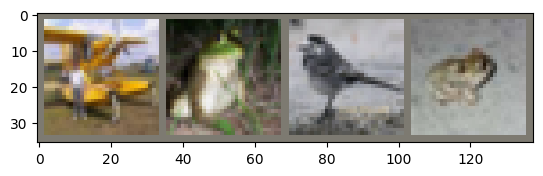

plane  frog  bird  frog


In [131]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img * np.array(std)[:,None,None] + np.array(mean)[:,None,None] # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images[:4], labels[:4]
print(images.size())
# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [132]:
assert torch.cuda.is_available(), "Notebook is not configured properly!"
print('Congrats, you\'re running this code on a', torch.cuda.get_device_name(), 'gpu')
device = 'cuda:0'

net = VGG16(num_classes=10,cifar=True).to(device)

# Nothing works w/o Batch Norm or Proper Initialization
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
initialize_weights(net)

# define here the Pytorch objects needed for training
crit = nn.CrossEntropyLoss() # loss criterion
optim = torch.optim.Adam(net.parameters()) # optimizer
epochs = 10

Congrats, you're running this code on a Tesla T4 gpu


Training loop

In [ ]:
from datetime import datetime
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt

print("Starting training...")
for e in range(epochs):
    # magic progress bar printer
    pbar = tqdm(total=len(trainloader), desc=f'Epoch {e} - 0%')
    
    # training loop
    for i, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        # forward pass goes here
        y_hat = net(x)
        loss = crit(y_hat, y)
        loss.backward()

        # logging functions
        pbar.update(1)
        pbar.set_description(f'Epoch {e} - {round(i/len(trainloader) * 100)}% -- loss {loss.item():.2f}')
        optim.step()
    

    corr = 0

    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            pred = net(x)

            pred = pred.view(pred.size(0),-1)
            
            corr += torch.sum(pred.max(dim=1)[0] == y)
    print(f"Accuracy for epoch {e}:{corr / len(testset)}")
print("Ending training...")

Starting training...


Epoch 0 - 0%:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 0:0.050999999046325684


Epoch 1 - 0%:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 1:0.05199999734759331


Epoch 2 - 0%:   0%|          | 0/782 [00:00<?, ?it/s]